# Basic Lhotse Workflow

This notebook shows how to write a dataloading pipeline for ASR using mini LibriSpeech dataset, so that the download is quick.

We don't pre-compute the features here for simplicity; in real workflows you might want to precompute them if your disks are slow to read. We will demonstrate that in a separate tutorial.

Optionally, uncomment the cells that download RIRs and MUSAN data to enable on-the-fly RIR reverberation and additive noise.

In [1]:
# Optional auto-formatting

#!pip install nb_black
#%load_ext lab_black

In [2]:
# Get the latest version of Lhotse, if not installed:

#!pip install git+https://github.com/lhotse-speech/lhotse

In [3]:
import os
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path

import torch
from torch.utils.data import DataLoader

from lhotse import CutSet, Fbank, RecordingSet
from lhotse.dataset import (
    CutMix,
    DynamicBucketingSampler,
    K2SpeechRecognitionDataset,
    OnTheFlyFeatures,
    PerturbSpeed,
    PerturbVolume,
    RandomizedSmoothing,
    ReverbWithImpulseResponse,
    SpecAugment,
)
from lhotse.recipes import (
    download_librispeech,
    download_musan,
    download_rir_noise,
    prepare_librispeech,
    prepare_musan,
    prepare_rir_noise,
)

In [4]:
root_dir = Path("data")
num_jobs = os.cpu_count() - 1

# (mini) LibriSpeech

We're downloading the data, preparing recording/supervision manfiests, and compiling them into CutSets. 
A cut is a basic "example" of data in Lhotse.

Approx. download size 450MB.

In [5]:
# libri_variant = "librispeech"
libri_variant = "mini_librispeech"
libri_root = download_librispeech(root_dir, dataset_parts=libri_variant)
libri = prepare_librispeech(
    libri_root, dataset_parts=libri_variant, output_dir=root_dir, num_jobs=num_jobs
)
cuts_train = CutSet.from_manifests(**libri["train-clean-5"]).trim_to_supervisions()
cuts_dev = CutSet.from_manifests(**libri["dev-clean-2"]).trim_to_supervisions()

Dataset parts:   0%|          | 0/2 [00:00<?, ?it/s]

# [Optional] Room impulse responses for reverb

Uncomment to enable reverberation in training dataloader (approx. download size 1GB).

In [6]:
rir_recordings = RecordingSet()
# rir_raw_dir = download_rir_noise(root_dir)
# rirs = prepare_rir_noise(rir_raw_dir, output_dir=root_dir, parts=["sim_rir"])
# rir_recordings = rirs["sim_rir"]["recordings"]

# [Optional] MUSAN for noise augmentation

Uncomment to enable additive noise in training dataloader (approx. download size 10GB).

In [7]:
musan_cuts = CutSet()
# musan_raw_dir = download_musan(root_dir)
# musan = prepare_musan(musan_raw_dir, output_dir=root_dir)
# musan_cuts = CutSet.from_manifests(
#     recordings=(
#         musan["music"]["recordings"]
#         + musan["noise"]["recordings"]
#         + musan["speech"]["recordings"]
#     )
# )

# Training DataLoader

Training DataLoader consists of two main classes. 
Sampler decides how examples are put together into batches.
Dataset convert a mini-batch of cuts (meta-data) into a dictionary of tensors used for training.
You can find more details at: https://lhotse.readthedocs.io/en/latest/datasets.html

In this example we use a `K2SpeechRecognitionDataset` for k2-specific ASR, which can be customized with augmentation transforms. For your own applications, you may want to write your own dataset class, but all of the other components should work for you without modifications.

To see actual recipes of training ASR with k2 and Lhotse, visit https://github.com/k2-fsa/icefall

The dataloader's batch_size has to be set to None since we already performed batching in the sampler.

In [8]:
# Training dataset has augmentations
train_sampler = DynamicBucketingSampler(
    cuts_train,
    shuffle=True,
    max_duration=100.0,
    num_buckets=10,
)

train_dataset = K2SpeechRecognitionDataset(
    cut_transforms=[
        PerturbSpeed(factors=[0.9, 1.1], p=2 / 3),
        PerturbVolume(scale_low=0.125, scale_high=2.0, p=0.5),
        # [optional] you can supply noise examples to be mixed in the data
        CutMix(musan_cuts, snr=[10, 20], p=0.5),
        # [optional] you can supply RIR examples to reverberate the data
        ReverbWithImpulseResponse(rir_recordings, p=0.5),
    ],
    input_transforms=[
        SpecAugment(),  # default configuration is well-tuned
    ],
    input_strategy=OnTheFlyFeatures(Fbank()),
)

train_dloader = DataLoader(
    train_dataset,
    sampler=train_sampler,
    batch_size=None,
    num_workers=0,  # For faster dataloading, use num_workers > 1
)

/Users/pzelasko/meaning/lhotse/lhotse/dataset/sampling/dynamic_bucketing.py:113: UserWarning: You are using DynamicBucketingSampler with an eagerly read CutSet. You won't see any memory/speed benefits with that setup. Either use 'CutSet.from_jsonl_lazy' to read the CutSet lazily, or use a BucketingSampler instead.
  warnings.warn(
/Users/pzelasko/meaning/lhotse/lhotse/dataset/cut_transforms/mix.py:41: UserWarning: Empty CutSet in CutMix transform: it'll act as an identity transform.
  warnings.warn(
/Users/pzelasko/meaning/lhotse/lhotse/dataset/cut_transforms/reverberate.py:26: UserWarning: Empty recording list in ReverbWithImpulseResponse: it will act as an identity transform.
  warnings.warn(


### Visualisation

Notice that the training mini-batch examples are perturbed in different ways, e.g. masking from SpecAugment.

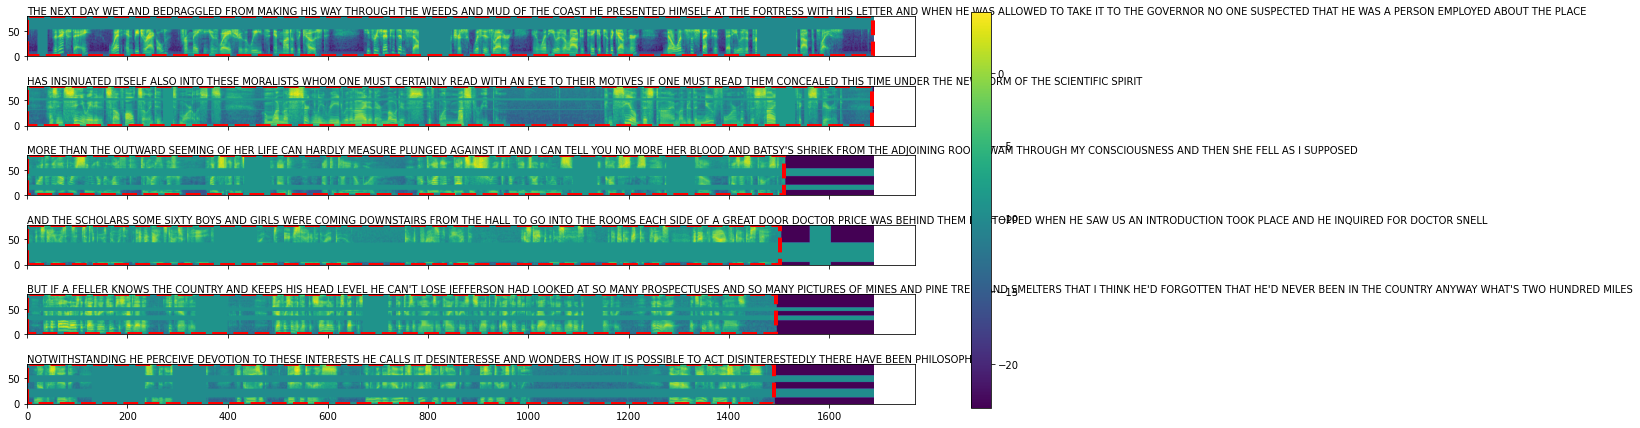

In [9]:
from lhotse.dataset.vis import plot_batch

for batch in train_dloader:
    plot_batch(batch)
    break

# Dev DataLoader

For dev data, we don't want to use any augmentations, so we create another dataset that doesn't have them.

In [10]:
# Dev dataset doesn't have any augmentation
dev_dataset = K2SpeechRecognitionDataset(
    input_strategy=OnTheFlyFeatures(Fbank()),
)
dev_sampler = DynamicBucketingSampler(
    cuts_dev, shuffle=False, max_duration=100.0, num_buckets=5
)
dev_dloader = DataLoader(
    dev_dataset,
    sampler=dev_sampler,
    batch_size=None,
    num_workers=0,  # For faster dataloading, use num_workers > 1
)

/Users/pzelasko/meaning/lhotse/lhotse/dataset/sampling/dynamic_bucketing.py:113: UserWarning: You are using DynamicBucketingSampler with an eagerly read CutSet. You won't see any memory/speed benefits with that setup. Either use 'CutSet.from_jsonl_lazy' to read the CutSet lazily, or use a BucketingSampler instead.
  warnings.warn(


### Visualisation

Notice that the training mini-batch examples are perturbed in different ways, e.g. masking from SpecAugment.

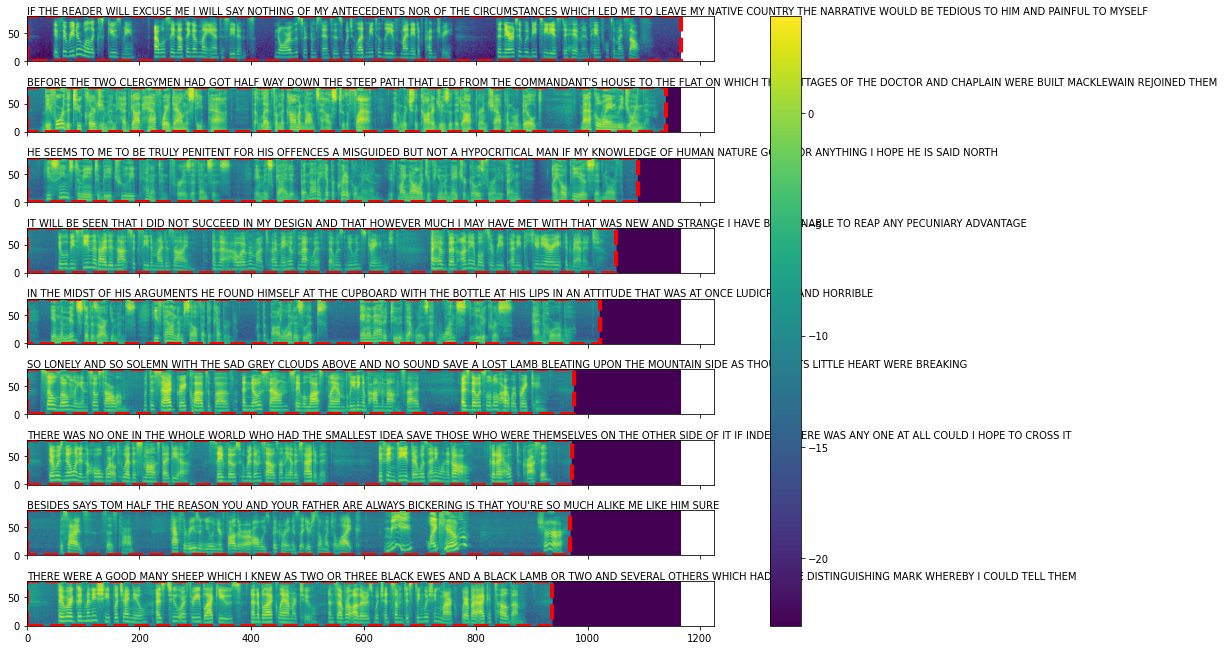

In [11]:
from lhotse.dataset.vis import plot_batch

for batch in dev_dloader:
    plot_batch(batch)
    break